In [1]:
from netCDF4 import Dataset
import numpy as np
from cartoplot import cartoplot
from regrid import regrid
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
import tqdm
import matplotlib.pyplot as plt

/home/robbie/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
d = Dataset('/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201103-fv2p3.nc')

AWI_lons = np.array(d['lon'])
AWI_lats = np.array(d['lat'])

###

d = Dataset('/home/robbie/Dropbox/SM_Thickness/data/Components/2015_components.nc')

RDCM_lons = np.array(d['lon'])
RDCM_lats = np.array(d['lat'])

###

d = Dataset('/media/robbie/TOSHIBA EXT/nsidc_SIT_march/RDEFT4_20150330.nc')

NSIDC_lons = np.array(d['lon'])
NSIDC_lats = np.array(d['lat'])

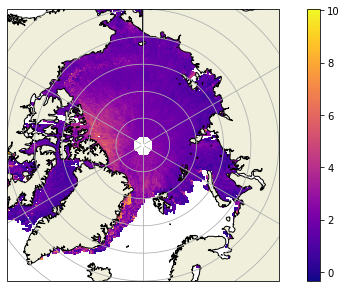

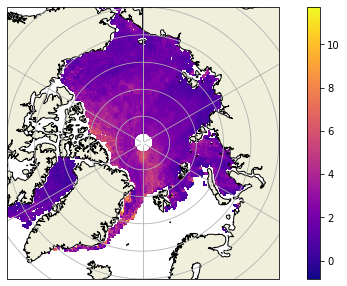

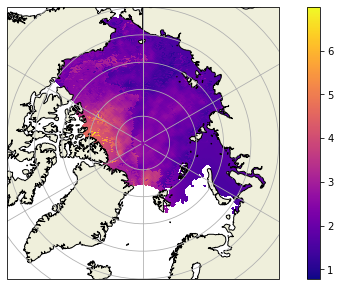

In [3]:
def get_march_AWI_SIT(year):
    
    d = Dataset(f'/home/robbie/Dropbox/SM_Thickness/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-{year}03-fv2p3.nc')
    
    SIT = np.array(d['sea_ice_thickness'][0])
    
    return SIT

def get_march_RDCM_SIT(year):
    
    d = Dataset(f'/home/robbie/Dropbox/SM_Thickness/data/Components/{year}_components.nc')
    
    SIT = np.array(d['M2'][2]) + np.array(d['free'][2])
    
    return SIT

def get_march_NSIDC_SIT(year):
    
    d = Dataset(f'/media/robbie/TOSHIBA EXT/nsidc_SIT_march/RDEFT4_{year}0330.nc')
    
    SIT = np.array(d['sea_ice_thickness'])
    
    SIT[SIT<-9000] = np.nan
    
    return SIT


AWI_sit_2015 = get_march_AWI_SIT(2015)

cartoplot(AWI_lons,AWI_lats,AWI_sit_2015)


RDCM_sit_2015 = get_march_RDCM_SIT(2015)

cartoplot(RDCM_lons,RDCM_lats,RDCM_sit_2015)


NSIDC_sit_2015 = get_march_NSIDC_SIT(2015)

cartoplot(NSIDC_lons,NSIDC_lats,NSIDC_sit_2015)


In [4]:
grid_cell_area = 25_067.53**2

In [5]:
AWI_vols = []
AWI_exts = []
AWI_mean = []


NSIDC_vols = []
RDCM_vols = []

years = np.arange(2011,2021)

for year in tqdm.tqdm(years):
    
    AWI_sit = get_march_AWI_SIT(year)

    RDCM_sit = get_march_RDCM_SIT(year)

    NSIDC_sit = get_march_NSIDC_SIT(year)
    
    AWI_sit_r = regrid(AWI_sit,AWI_lons,AWI_lats,RDCM_lons,RDCM_lats,method='linear')
    NSIDC_sit_r = regrid(NSIDC_sit,NSIDC_lons,NSIDC_lats,RDCM_lons,RDCM_lats,method='linear')
    
    composite = AWI_sit_r + RDCM_sit + NSIDC_sit_r
    
    AWI_sit_r[np.isnan(composite)] = np.nan
    AWI_sit_r[AWI_sit_r==0] = np.nan
    RDCM_sit[np.isnan(composite)] = np.nan
    NSIDC_sit_r[np.isnan(composite)] = np.nan

    AWI_vols.append( np.nansum(AWI_sit_r)*grid_cell_area/1e9  )
    AWI_exts.append( np.count_nonzero(np.nan_to_num(AWI_sit_r))*grid_cell_area/1e6  )
    AWI_mean.append( np.nanmean(AWI_sit_r)  )
    
    NSIDC_vols.append( np.nansum(NSIDC_sit_r)*grid_cell_area/1e9  )
    RDCM_vols.append( np.nansum(RDCM_sit)*grid_cell_area/1e9  )

100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


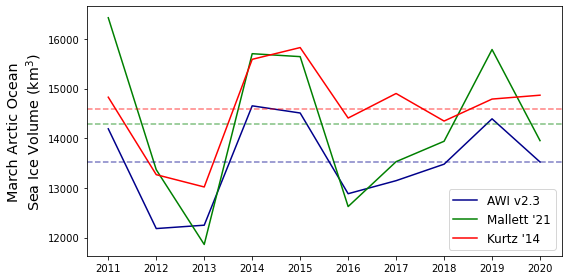

In [8]:
plt.figure(figsize=(8,4))

plt.plot(years,AWI_vols,label='AWI v2.3',color='darkblue')
plt.plot(years,RDCM_vols,label="Mallett '21",color='g')
plt.plot(years,NSIDC_vols,label="Kurtz '14",color='r')

plt.axhline(np.mean(NSIDC_vols),color='r',ls='--',alpha=0.5)
plt.axhline(np.mean(AWI_vols),color='darkblue',ls='--',alpha=0.5)
plt.axhline(np.mean(RDCM_vols),color='g',ls='--',alpha=0.5)

plt.ylabel('March Arctic Ocean\nSea Ice Volume (km$^3$)',fontsize='x-large')
plt.xticks(years)
plt.legend(fontsize='large')

plt.tight_layout()

data_dir = '/home/robbie/Dropbox/Apps/Overleaf/Book_chapter/figs'
plt.savefig(f'{data_dir}/fig6_c.jpg',dpi=500, bbox_inches='tight')

plt.show()

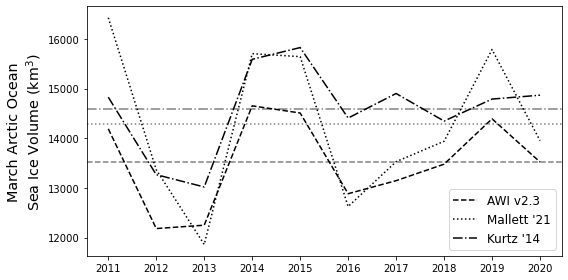

In [9]:
plt.figure(figsize=(8,4))

plt.plot(years,AWI_vols,label='AWI v2.3',color='k',ls='--')
plt.plot(years,RDCM_vols,label="Mallett '21",color='k',ls=':')
plt.plot(years,NSIDC_vols,label="Kurtz '14",color='k',ls='-.')

plt.axhline(np.mean(NSIDC_vols),color='k',ls='-.',alpha=0.5)
plt.axhline(np.mean(AWI_vols),color='k',ls='--',alpha=0.5)
plt.axhline(np.mean(RDCM_vols),color='k',ls=':',alpha=0.5)

plt.ylabel('March Arctic Ocean\nSea Ice Volume (km$^3$)',fontsize='x-large')
plt.xticks(years)
plt.legend(fontsize='large')

plt.tight_layout()

data_dir = '/home/robbie/Dropbox/Apps/Overleaf/Book_chapter/figs'
plt.savefig(f'{data_dir}/fig6_bw.jpg',dpi=500, bbox_inches='tight')

plt.show()

# Old figure

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


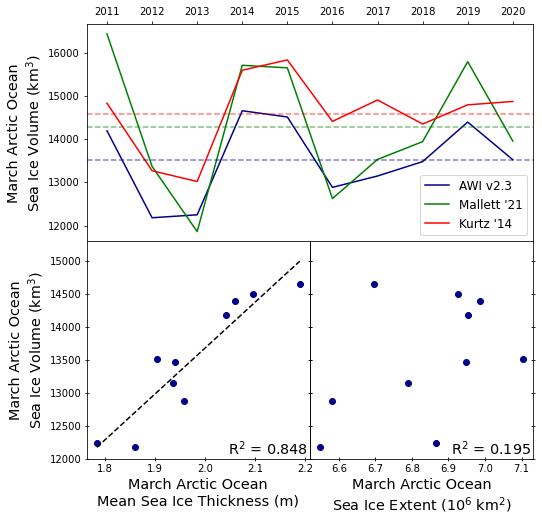

In [113]:
fig = plt.figure(constrained_layout=True,figsize=(8,8))

gs = fig.add_gridspec(2, 2)

top_ax = fig.add_subplot(gs[0, :])

top_ax.plot(years,AWI_vols,label='AWI v2.3',color='darkblue')
top_ax.plot(years,RDCM_vols,label="Mallett '21",color='g')
top_ax.plot(years,NSIDC_vols,label="Kurtz '14",color='r')

top_ax.axhline(np.mean(AWI_vols),color='darkblue',ls='--',alpha=0.5)
top_ax.axhline(np.mean(NSIDC_vols),color='r',ls='--',alpha=0.5)
top_ax.axhline(np.mean(RDCM_vols),color='g',ls='--',alpha=0.5)

top_ax.set_ylabel('March Arctic Ocean\nSea Ice Volume (km$^3$)',fontsize='x-large')
top_ax.set_xticks(years)
top_ax.legend(fontsize='large')

top_ax.xaxis.set_label_position('top') 
top_ax.xaxis.tick_top()

###

BR_ax = fig.add_subplot(gs[1:, -1])


BR_ax.scatter(np.array(AWI_exts)/1e6,AWI_vols,color='darkblue')

reg = linregress(AWI_exts, AWI_vols)

BR_ax.annotate(xy=(0.99,0.02),ha='right',
               text=f'R$^2$ = {np.round(reg[2]**2,decimals=3)}',
               xycoords='axes fraction',
               fontsize='x-large')

BR_ax.set_yticklabels([])
BR_ax.yaxis.set_ticks_position('both')
BR_ax.tick_params(direction='inout')
BR_ax.set_ylim(12000,15300)
BR_ax.set_xlabel('March Arctic Ocean\nSea Ice Extent (10$^6$ km$^2$)',fontsize='x-large')


###

BL_ax = fig.add_subplot(gs[1, :-1])

reg = linregress(AWI_mean, AWI_vols)

BL_ax.annotate(xy=(0.99,0.02),ha='right',
               text=f'R$^2$ = {np.round(reg[2]**2,decimals=3)}',
               xycoords='axes fraction',
               fontsize='x-large')

BL_ax.scatter(AWI_mean,AWI_vols,color='darkblue')

BL_ax.set_ylabel('March Arctic Ocean\nSea Ice Volume (km$^3$)',fontsize='x-large')
BL_ax.yaxis.set_ticks_position('both')
BL_ax.tick_params(direction='inout')
BL_ax.set_ylim(12000,15300)
BL_ax.set_xlabel('March Arctic Ocean\nMean Sea Ice Thickness (m)',fontsize='x-large')

BL_ax.plot([np.min(AWI_mean),np.max(AWI_mean)],
           [np.min(AWI_mean)*reg[0]+reg[1],np.max(AWI_mean)*reg[0]+reg[1]],
           color='k',ls="--")

plt.subplots_adjust(wspace=0.0, hspace=0)

plt.show()